In [2]:
import pandas as pd
import numpy as np, gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

%matplotlib inline

In [175]:
#read in the cvs file making the transactionIDs the row labels rather than just another variable (so can be merged)
#read in the cvs file making the transactionIDs the row labels rather than just another variable (so can be merged)

train_identity = pd.read_csv('/Users/owencrew/Documents/ID/Project 2/ieee-fraud-detection/train_identity.csv', index_col='TransactionID')
train_transaction = pd.read_csv('/Users/owencrew/Documents/ID/Project 2/ieee-fraud-detection/train_transaction.csv', index_col='TransactionID')
test_identity = pd.read_csv('/Users/owencrew/Documents/Uni/ID/Project 2/ieee-fraud-detection/test_identity.csv', index_col='TransactionID')
test_transaction = pd.read_csv('/Users/owencrew/Documents/ID/Project 2/ieee-fraud-detection/test_transaction.csv', index_col='TransactionID')



In [176]:
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)



print(train.shape)
print(test.shape)


(590540, 433)
(506691, 432)


In [177]:
y_train = train['isFraud']
train=train.drop(columns='isFraud')

In [178]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 2987000 to 3577539
Columns: 432 entries, TransactionDT to DeviceInfo
dtypes: float64(399), int64(2), object(31)
memory usage: 1.9+ GB


In [179]:
#inconsistency between the test and train in this variable
#ensure all columns are named the same 

test = test.rename(columns = {'id-01' : 'id_01', 'id-02' : 'id_02', 
                         'id-03' : 'id_03', 'id-04' : 'id_04', 
                         'id-05' : 'id_05', 'id-06' : 'id_06', 
                         'id-07' : 'id_07', 'id-08' : 'id_08', 
                         'id-09' : 'id_09', 'id-10' : 'id_10',
                         'id-11' : 'id_11', 'id-12' : 'id_12', 
                         'id-13' : 'id_13', 'id-14' : 'id_14', 
                         'id-15' : 'id_15', 'id-16' : 'id_16', 
                         'id-17' : 'id_17', 'id-18' : 'id_18', 
                         'id-19' : 'id_19', 'id-20' : 'id_20', 
                         'id-21' : 'id_21', 'id-22' : 'id_22', 
                         'id-23' : 'id_23', 'id-24' : 'id_24', 
                         'id-25' : 'id_25', 'id-26' : 'id_26', 
                         'id-27' : 'id_27', 'id-28' : 'id_28', 
                         'id-29' : 'id_29', 'id-30' : 'id_30', 
                         'id-31' : 'id_31', 'id-32' : 'id_32', 
                         'id-33' : 'id_33', 'id-34' : 'id_34', 
                         'id-35' : 'id_35', 'id-36' : 'id_36', 
                         'id-37' : 'id_37', 'id-38' : 'id_38'})

In [8]:
# sort covariates in to categorical and numeric

cat_cols = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
               'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1',
               'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo',
               'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20',
               'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
               'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

exclude = ['TransactionID', 'TransactionDT', 'isFraud']
num_cols = [c for c in train.columns if (c not in cat_cols) & (c not in exclude)]

In [180]:
# drop more than 90% nas 


col_na = train.isna().sum()
drop_na = col_na[(col_na/ train.shape[0]) > 0.9].index

use_cols = [c for c in train.columns if c not in drop_na]
cat_cols = [c for c in cat_cols if c not in drop_na]
num_cols = [c for c in num_cols if c not in drop_na]


train = train.drop(columns=drop_na)
test = test.drop(columns=drop_na)

In [181]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 2987000 to 3577539
Columns: 420 entries, TransactionDT to DeviceInfo
dtypes: float64(389), int64(2), object(29)
memory usage: 1.9+ GB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 3663549 to 4170239
Columns: 420 entries, TransactionDT to DeviceInfo
dtypes: float64(389), int64(2), object(29)
memory usage: 1.6+ GB


## Reduce V cols

Group columns based on a number of missing values

In each group, For each column in that group find the correlation with other columns and take only columns with a correlation coefficient > 0.75. Take the largest list with common elements as a subgroup.



Each group contains several subgroups. From each subgroup choose the column with the most number of unique values.

In [11]:
#transaction data columns that arent the Vs
cols_t = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']
#all the v columns
cols_v = ['V'+str(x) for x in range(1,340)]; types_v = {}



In [12]:
# search number of nas accross all vs and group together those columns with the exact same number of nas

nans = train.isna()
na_groups = {}
i_cols = ['V'+str(i) for i in range(1,340)]
for col in train.columns:
    group_x = nans[col].sum()
    try:
        na_groups[group_x].append(col)
    except:
        na_groups[group_x] = [col]
del nans; x = gc.collect()

for n,v in na_groups.items():
    print('number of NA =', n)
    print(v)


number of NA = 0
['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
number of NA = 8933
['card2']
number of NA = 1565
['card3']
number of NA = 1577
['card4']
number of NA = 4259
['card5']
number of NA = 1571
['card6']
number of NA = 65706
['addr1', 'addr2']
number of NA = 352271
['dist1']
number of NA = 94456
['P_emaildomain']
number of NA = 453249
['R_emaildomain']
number of NA = 1269
['D1', 'V281', 'V282', 'V283', 'V288', 'V289', 'V296', 'V300', 'V301', 'V313', 'V314', 'V315']
number of NA = 280797
['D2']
number of NA = 262878
['D3']
number of NA = 168922
['D4']
number of NA = 309841
['D5']
number of NA = 517353
['D6']
number of NA = 515614
['D8', 'D9', 'id_09', 'id_10']
number of NA = 76022
['D10']
number of NA = 279287
['D11', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11']
number of NA = 525823
['D12']
number of NA = 528588
['D13']
number of NA = 528353
['D14']
numbe

We now look at V1 - V11 along with D11 as these are clearly linked with the exact same number of Nas. We want to decide which of these variables to keep, therefore we look at the proportion of Nas in each variable along with their correlations

# V1 - V11, D11

In [13]:
vc = ['dayr','isFraud','TransactionAmt','card1','addr1','D1n','D11n']
vs = na_groups[279287]
v_title = 'V1 - V11, D11'

We want to see which Vs are highly correlated with each other within th groups of Vs that have the same number of NAs. From this we can choose some Vs to get rid of.



In [14]:
def v_correlation(vs, v_title = ''):
    cols = ['TransactionDT'] + vs
    plt.figure(figsize = (15, 15))
    sns.heatmap(train[cols].corr(), cmap = 'RdBu_r', annot = True, center = 0.0)
    if v_title !='': plt.title(v_title, fontsize = 14)
    else: plt.title(vs[0]+' - '+ vs[-1], fontsize = 14)
    plt.show()
    
v_correlation(vs,v_title)

In [15]:
#should we specifiy a threshold correlation number for putting Vs in the same group?
groups = [[1],[2,3],[4,5],[6,7],[8,9],[10,11]]

def choose_v(groups, c='V'):
    use = []
    for g in groups:
        mx = 0; vx = g[0]
        for gg in g:
            n = train[c+str(gg)].nunique()
            if n > mx:
                mx = n
                vx = gg
        use.append(vx)
    print('Use these',use)
choose_v(groups)


Use these [1, 3, 4, 6, 8, 11]


Repeat this process for every group of linked vs.

# V12 - V34

In [16]:
vs = na_groups[76073]
v_correlation(vs)

In [17]:
groups = [[12,13],[14],[15,16,17,18,21,22,31,32,33,34],[19,20],[23,24],[25,26],[27,28],[29,30]]
choose_v(groups)


Use these [13, 14, 17, 20, 23, 26, 27, 30]


# V35 - V52

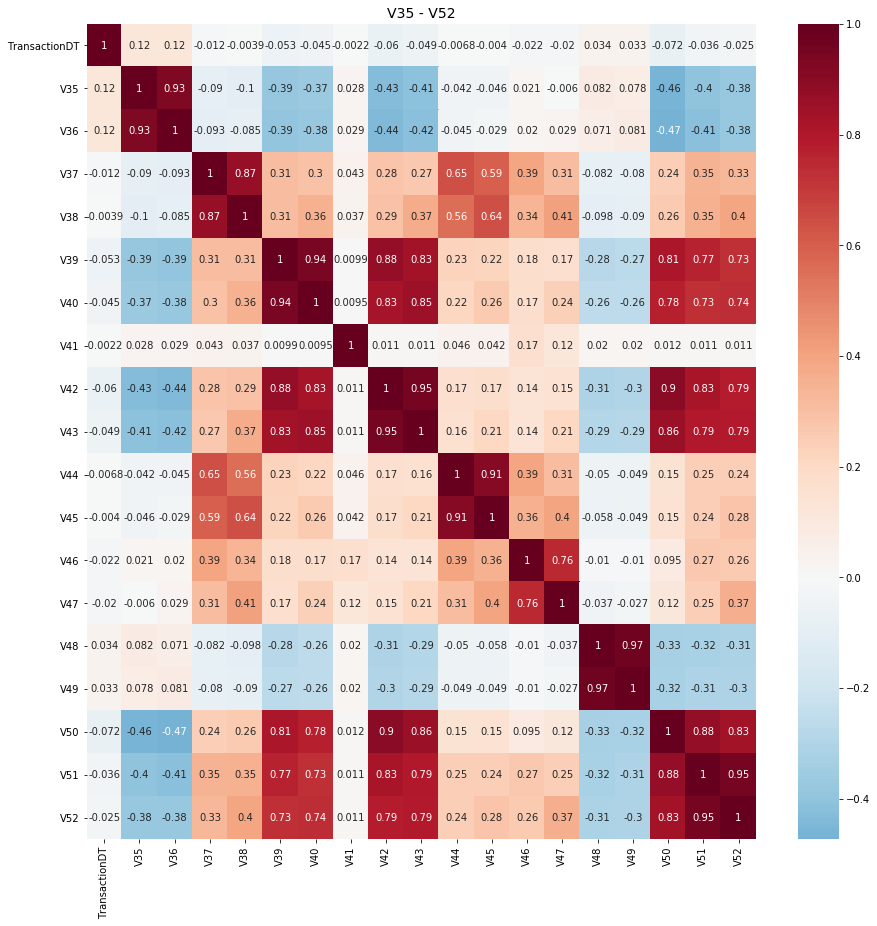

In [18]:
vs = na_groups[168969]
v_correlation(vs)

In [19]:
groups = [[35,36],[37,38],[39,40,42,43,50,51,52],[41],[44,45],[46,47],[48,49]]
choose_v(groups)


Use these [36, 37, 40, 41, 44, 47, 48]


# V53 - V74

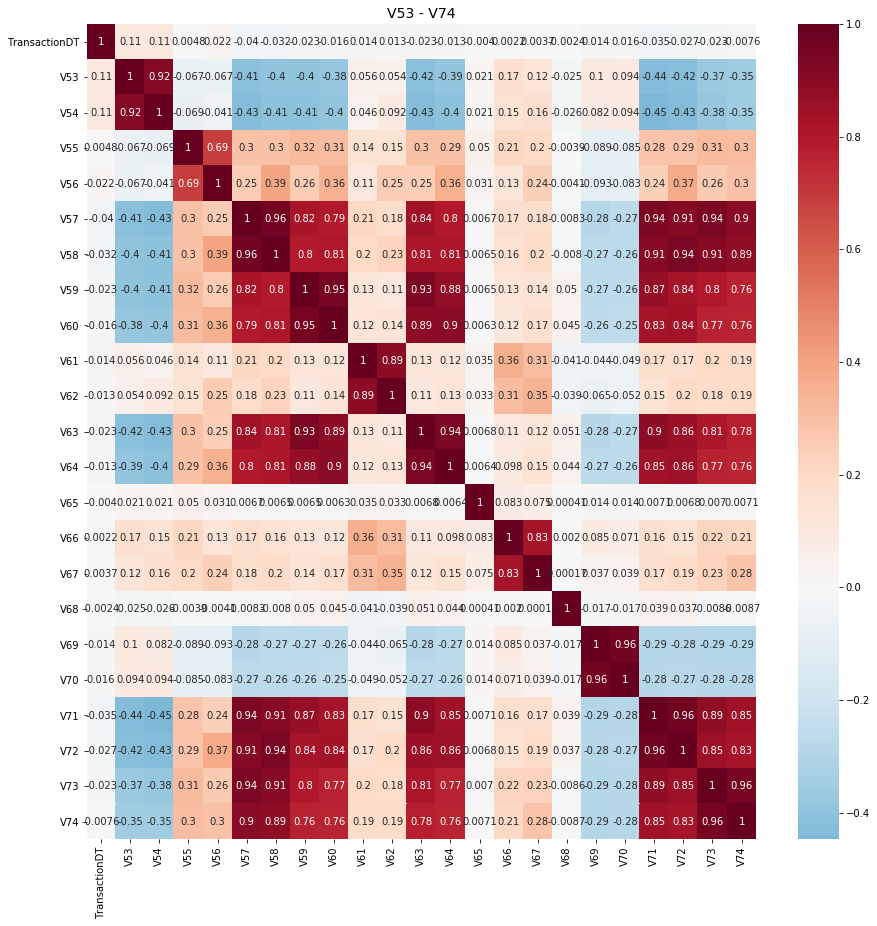

In [20]:
vs = na_groups[77096]
v_correlation(vs)

In [21]:
groups = [[53,54],[55,56],[57,58,59,60,63,64,71,72,73,74],[61,62],[65],[66,67],[68],[69,70]]
choose_v(groups)

Use these [54, 56, 59, 62, 65, 67, 68, 70]


# V75 - V94

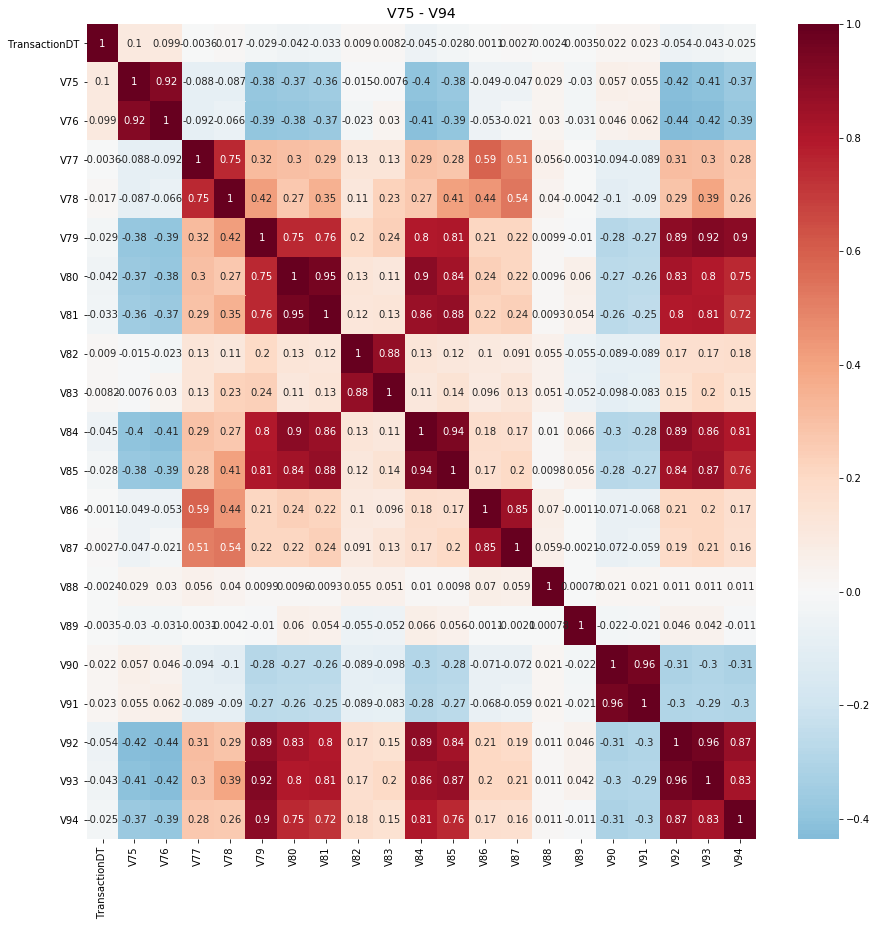

In [22]:
vs = na_groups[89164]
v_correlation(vs)


In [23]:
groups = [[75,76],[77,78],[79,80,81,84,85,92,93,94],[82,83],[86,87],[88],[89],[90,91]]
choose_v(groups)


Use these [76, 78, 80, 82, 86, 88, 89, 91]


# V95 - V137

In [24]:
vs = na_groups[314]
v_correlation(vs)

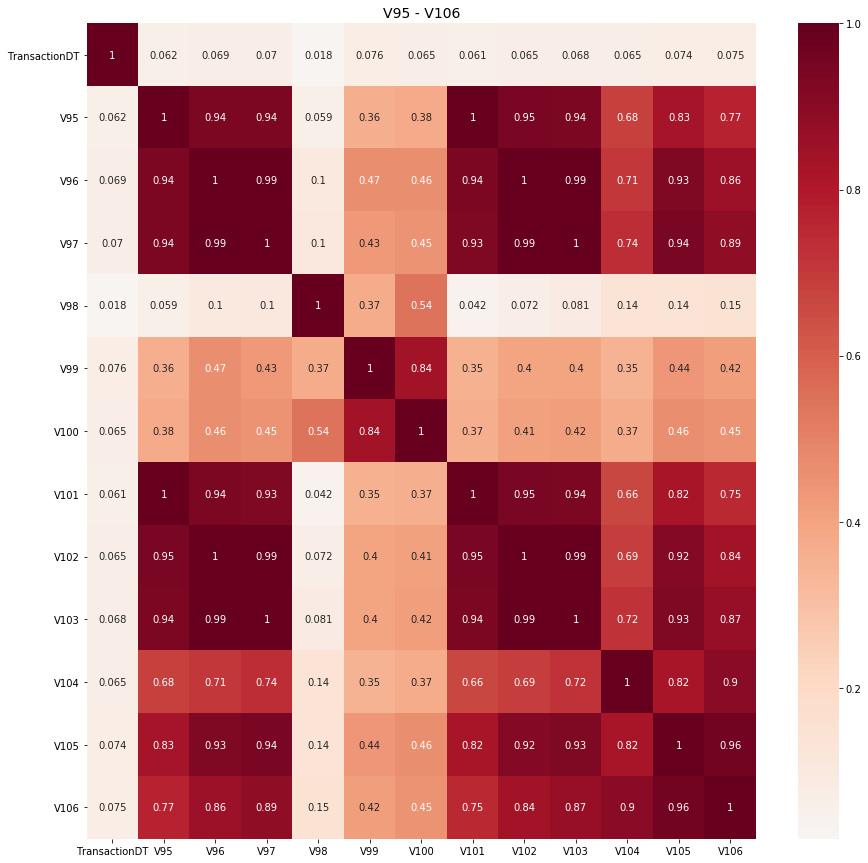

In [25]:
vs = ['V'+str(x) for x in range(95,107)]
v_correlation(vs)


In [26]:
groups = [[95,96,97,101,102,103,105,106],[98],[99,100],[104]]
choose_v(groups)


Use these [96, 98, 99, 104]


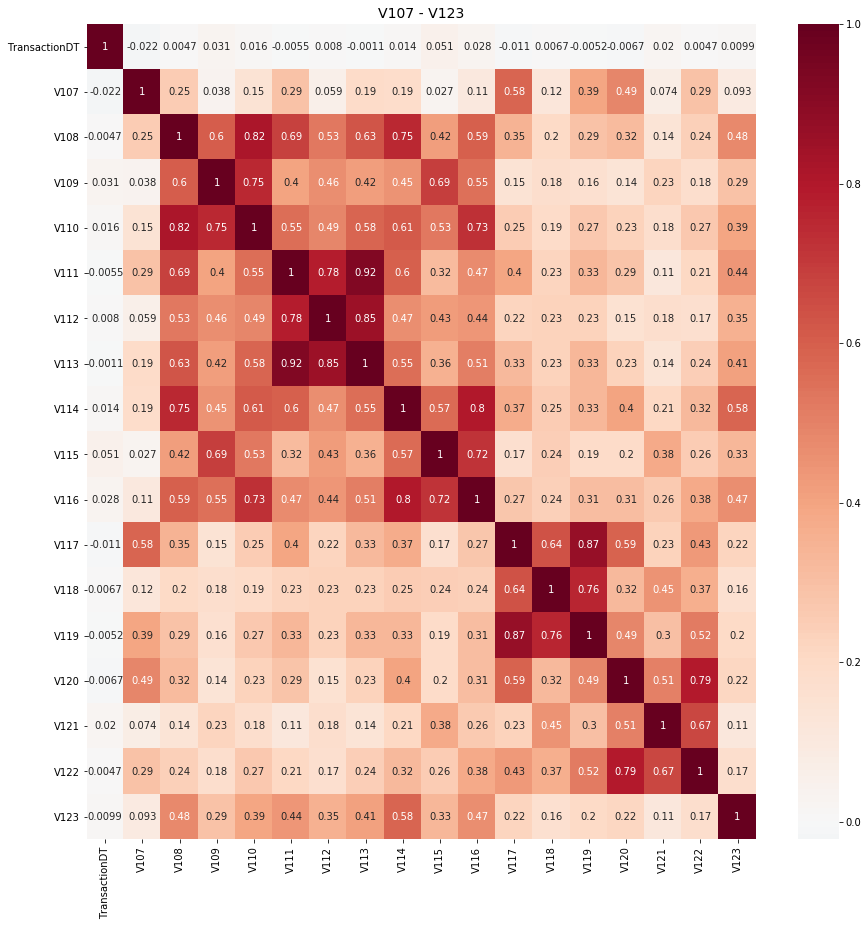

In [27]:
vs = ['V'+str(x) for x in range(107,124)]
v_correlation(vs)

In [28]:
groups = [[107],[108,109,110,114],[111,112,113],[115,116],[117,118,119],[120,122],[121],[123]]
choose_v(groups)

Use these [107, 108, 111, 115, 117, 120, 121, 123]


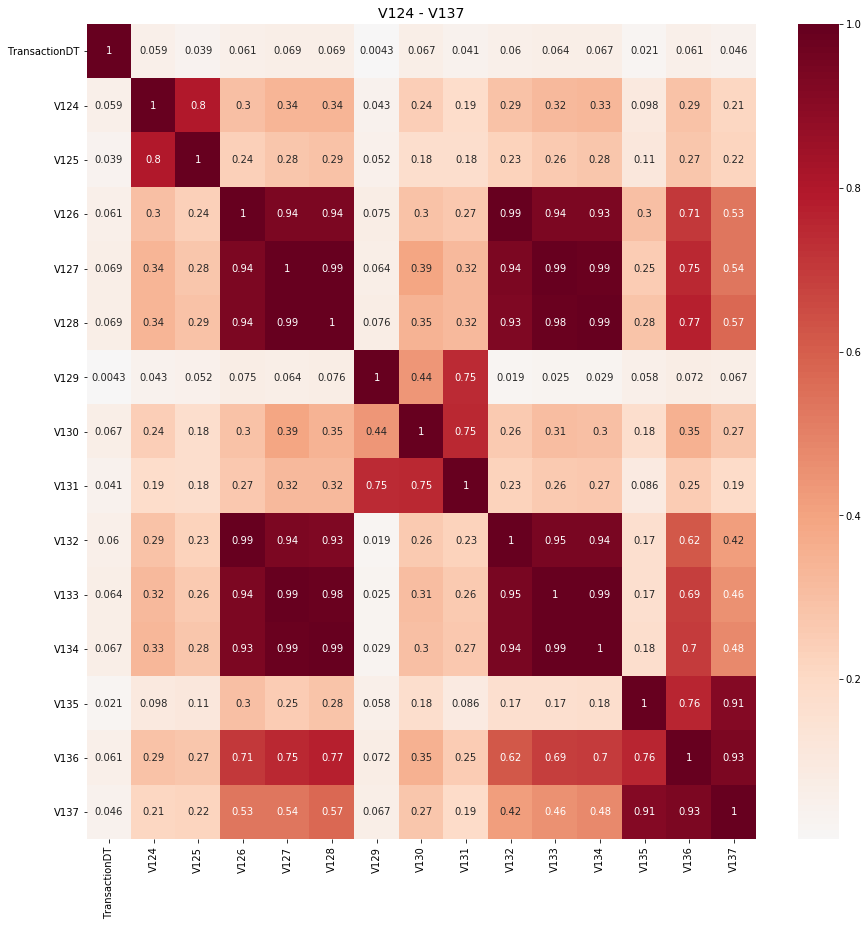

In [29]:
vs = ['V'+str(x) for x in range(124,138)]
v_correlation(vs)


In [30]:
groups = [[124,125],[126,127,128,132,133,134],[129],[130,131],[135,136,137]]
choose_v(groups)


Use these [124, 127, 129, 130, 136]


# V138 - V163

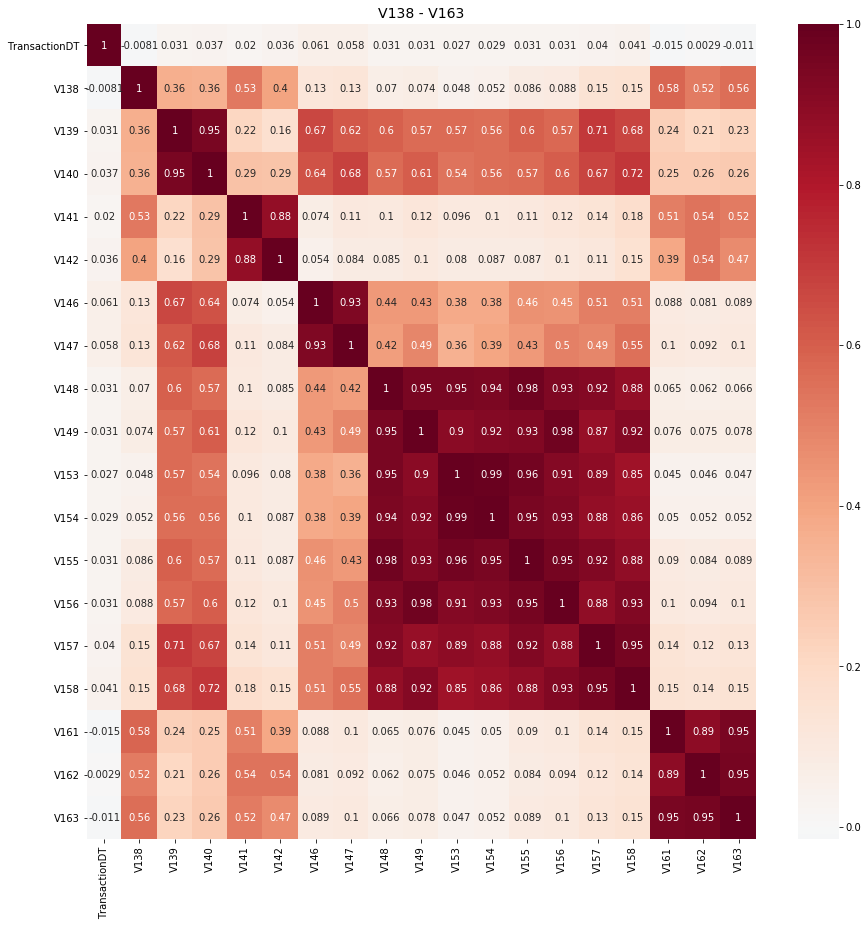

In [31]:
vs = na_groups[508595]
v_correlation(vs)

In [32]:
groups = [[138],[139,140],[141,142],[146,147],[148,149,153,154,156,157,158],[161,162,163]]
choose_v(groups)


Use these [138, 139, 142, 147, 156, 162]


# V143 - V166

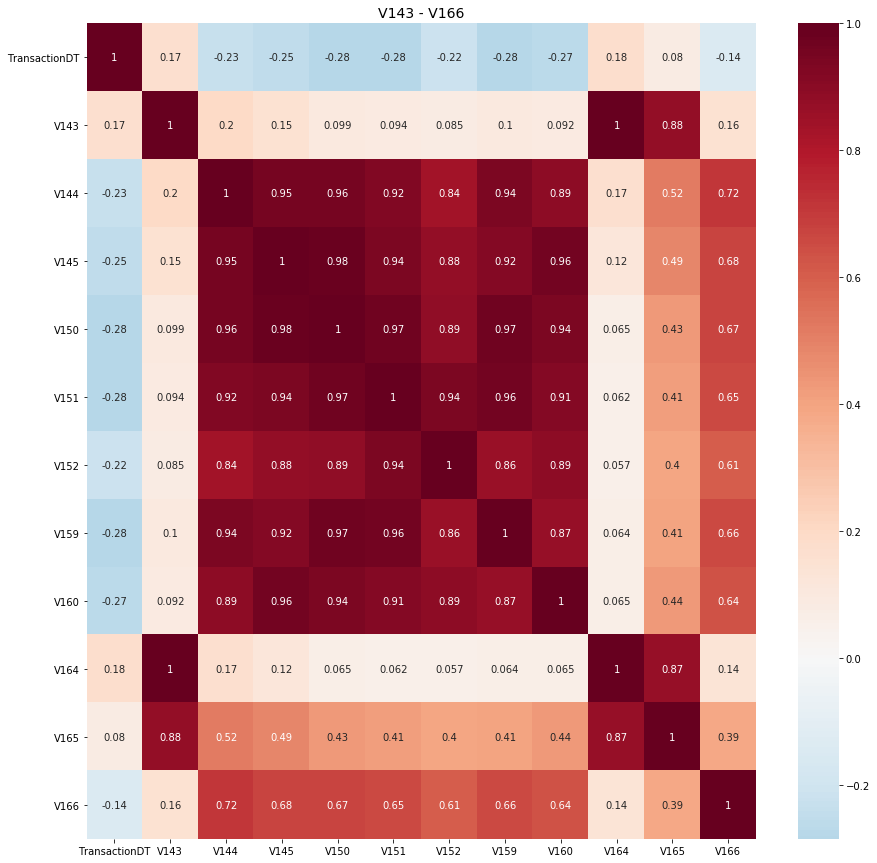

In [33]:
vs = na_groups[508589]
v_correlation(vs)


In [34]:
groups = [[143,164,165],[144,145,150,151,152,159,160],[166]]
choose_v(groups)

Use these [165, 160, 166]


# V167 - V216


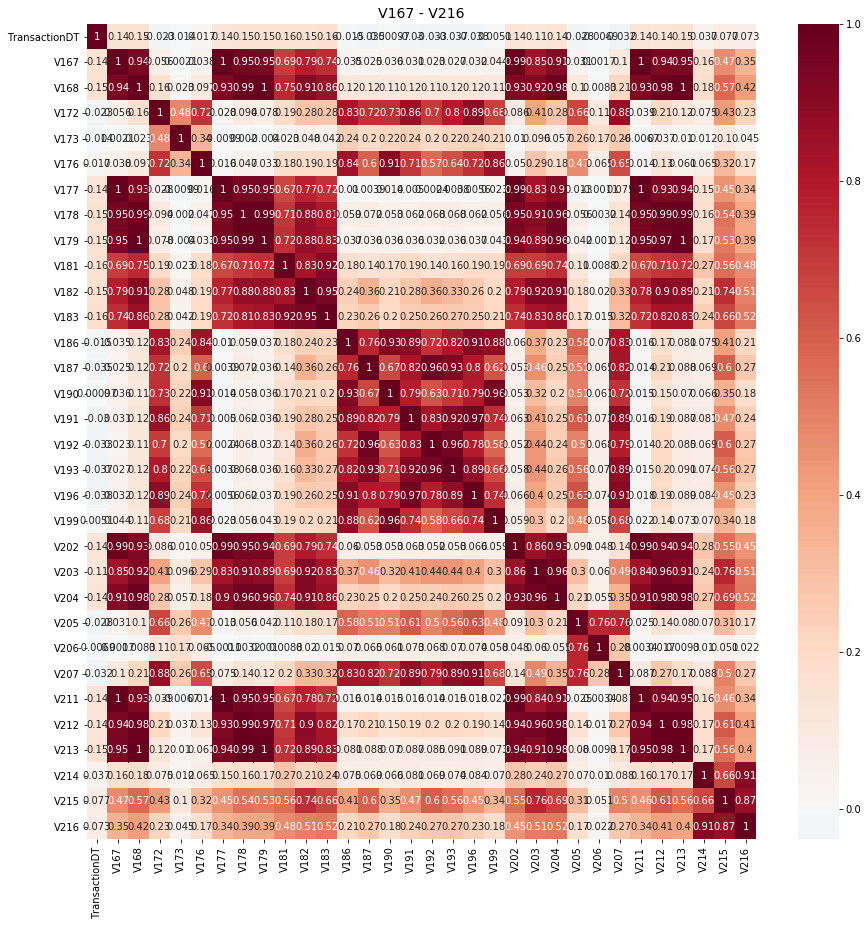

In [35]:
vs = [x for x in na_groups[450909]]
v_correlation(vs)


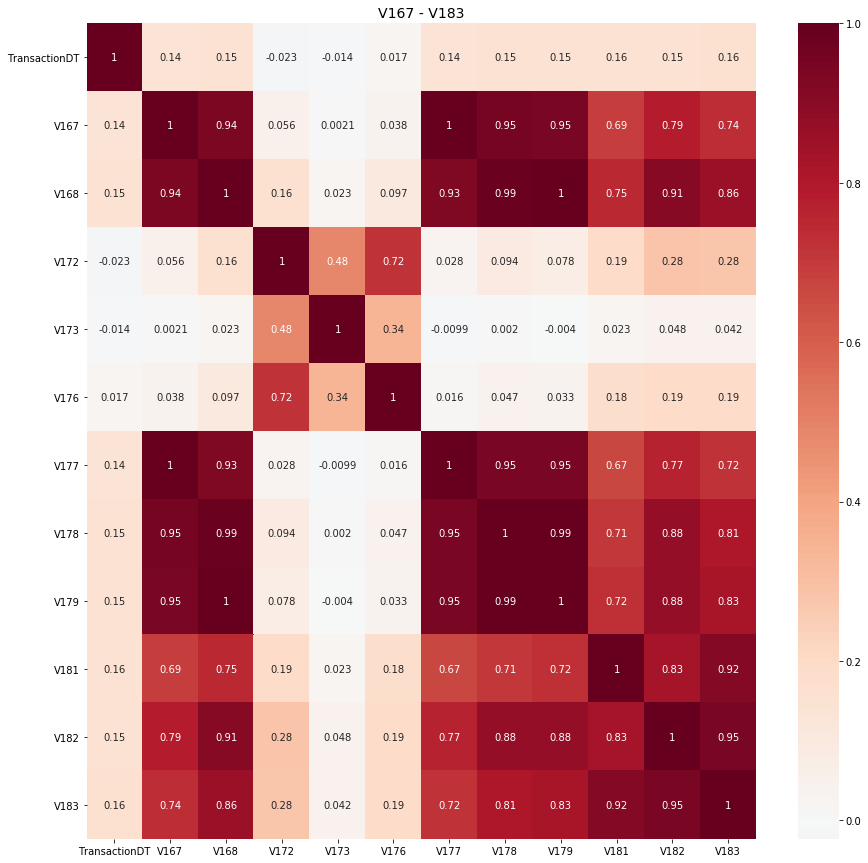

In [36]:
vs = [x for x in na_groups[450909] if int(x[1:]) < 186]
v_correlation(vs)


In [37]:
groups = [[167,168,177,178,179],[172,176],[173],[181,182,183]]
choose_v(groups)

Use these [178, 176, 173, 182]


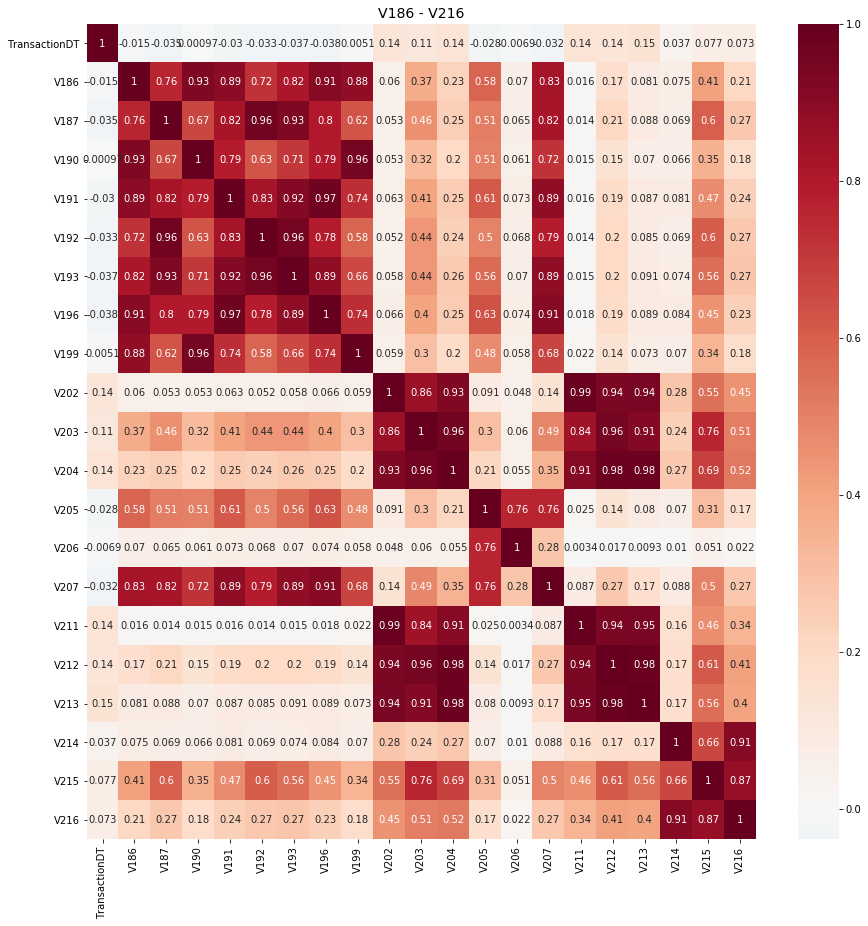

In [38]:
vs = [x for x in na_groups[450909] if (int(x[1:]) > 183)]
v_correlation(vs)

In [39]:
groups = [[186,187,190,191,192,193,196,199],[202,203,204,211,212,213],[205,206],[207],[214,215,216]]
choose_v(groups)

Use these [187, 203, 205, 207, 215]


# V169 - V210

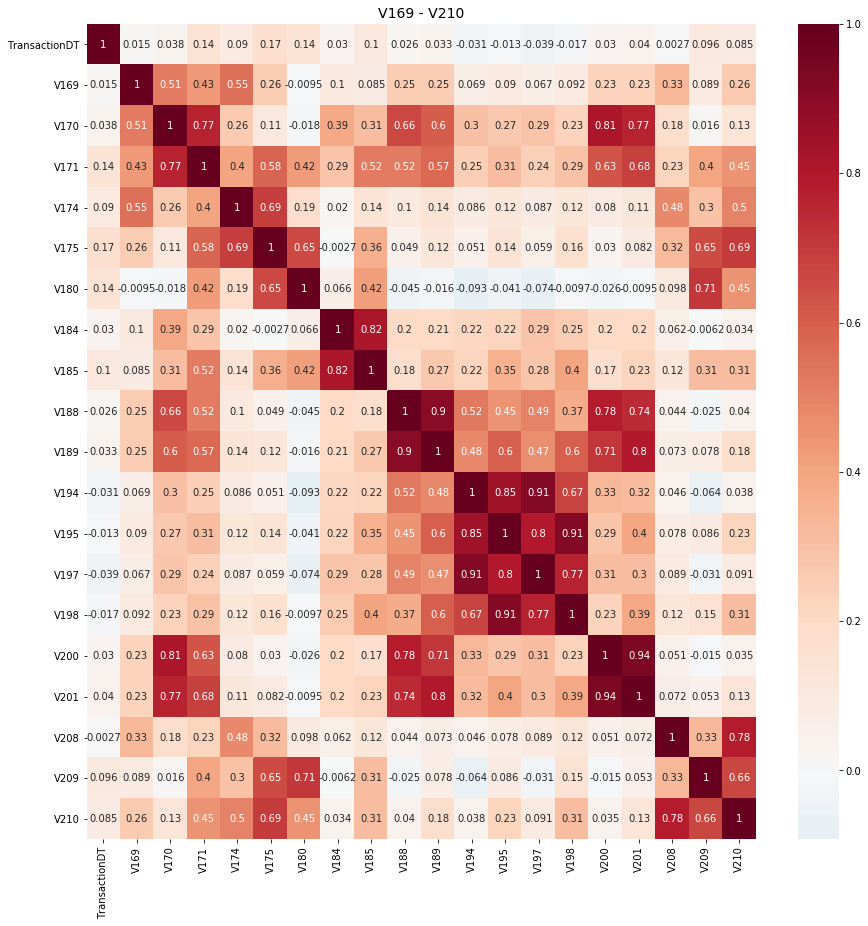

In [40]:
vs = na_groups[450721]
v_correlation(vs)


In [41]:
groups = [[169],[170,171,200,201],[174,175],[180],[184,185],[188,189],[194,195,197,198],[208,210],[209]]
choose_v(groups)


Use these [169, 171, 175, 180, 185, 188, 198, 210, 209]


# V217 - V278

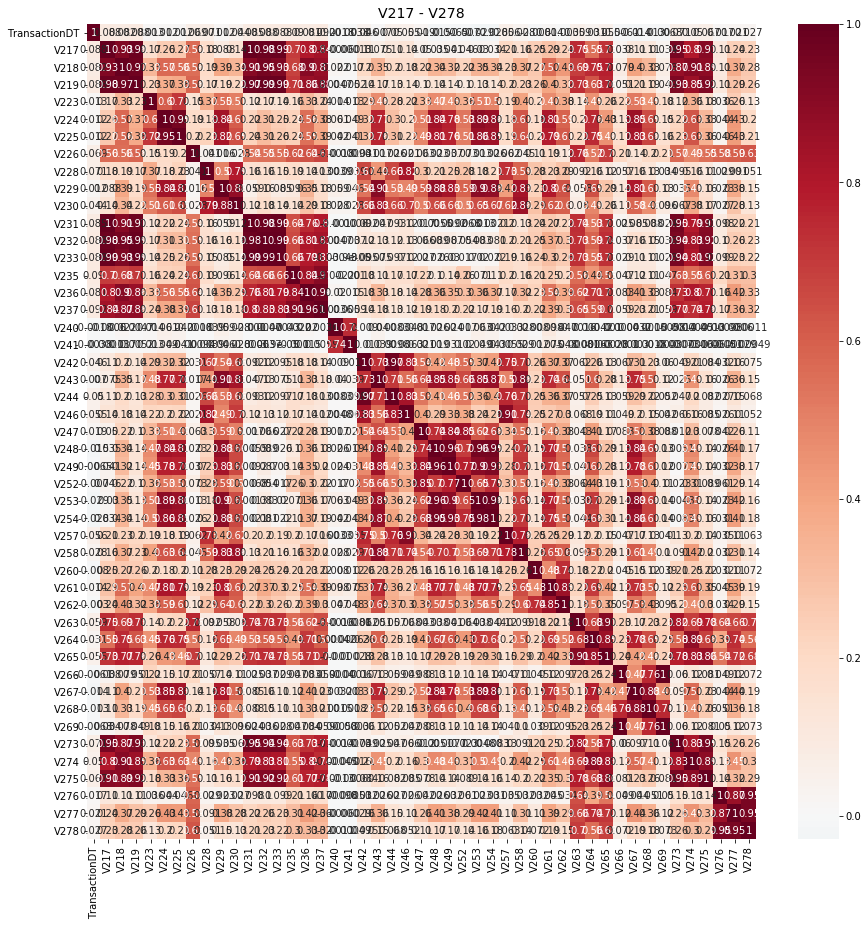

In [42]:
vs = [x for x in na_groups[460110]]
v_correlation(vs)

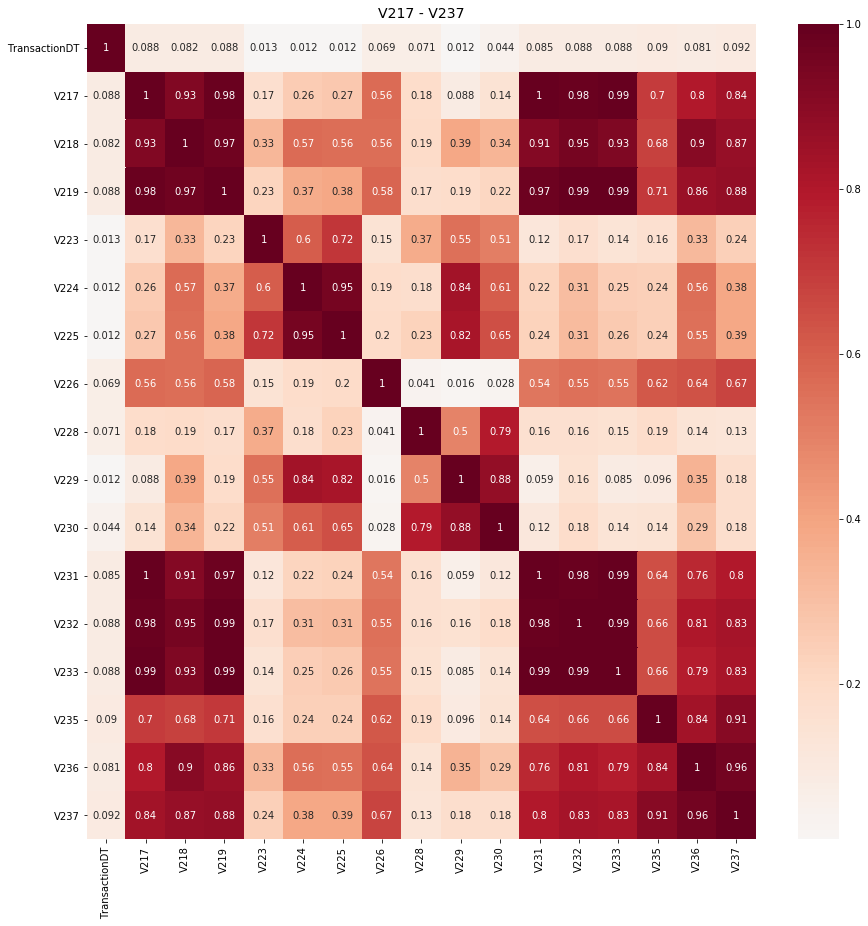

In [43]:
vs = [x for x in na_groups[460110] if int(x[1:]) < 240]
v_correlation(vs)


In [44]:
groups = [[217,218,219,231,232,233,236,237],[223],[224,225],[226],[228],[229,230],[235]]
choose_v(groups)


Use these [218, 223, 224, 226, 228, 229, 235]


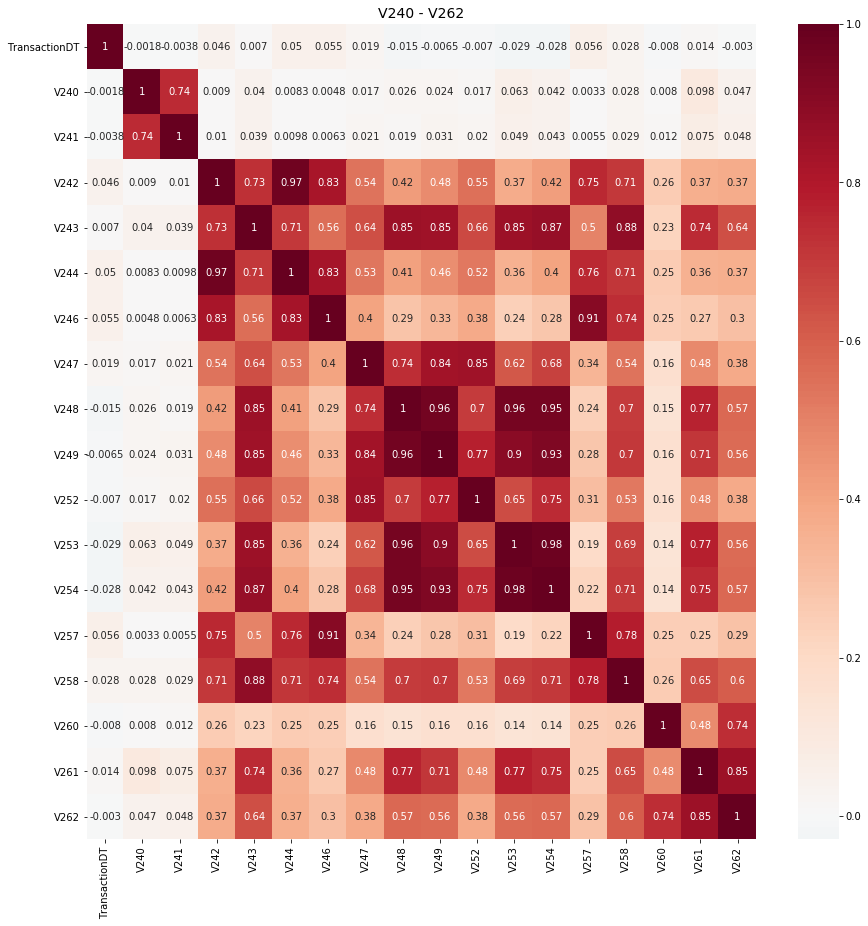

In [45]:
vs = [x for x in na_groups[460110] if (int(x[1:]) > 237) & (int(x[1:]) < 263)]
v_correlation(vs)


In [46]:

groups = [[240,241],[242,243,244,258],[246,257],[247,248,249,253,254],[252],[260],[261,262]]
choose_v(groups)


Use these [240, 258, 257, 253, 252, 260, 261]


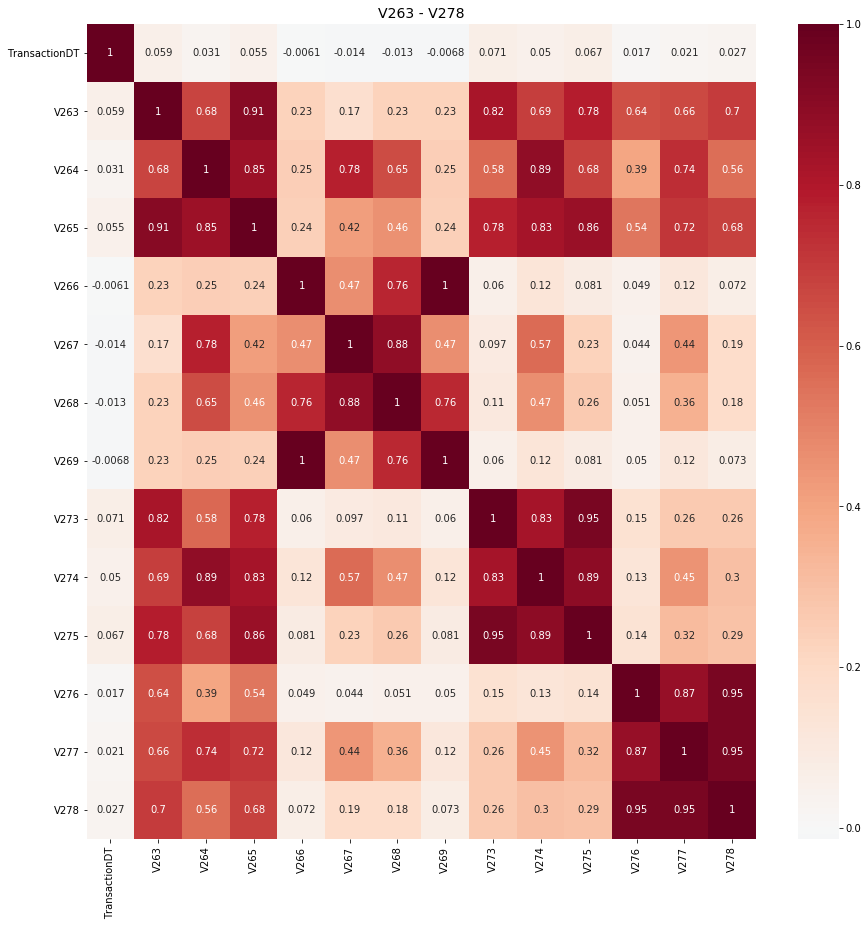

In [47]:
vs = [x for x in na_groups[460110] if (int(x[1:]) > 262)]
v_correlation(vs)

In [48]:
groups = [[263,265,264],[266,269],[267,268],[273,274,275],[276,277,278]]
choose_v(groups)

Use these [264, 266, 267, 274, 277]


# V220 - V272


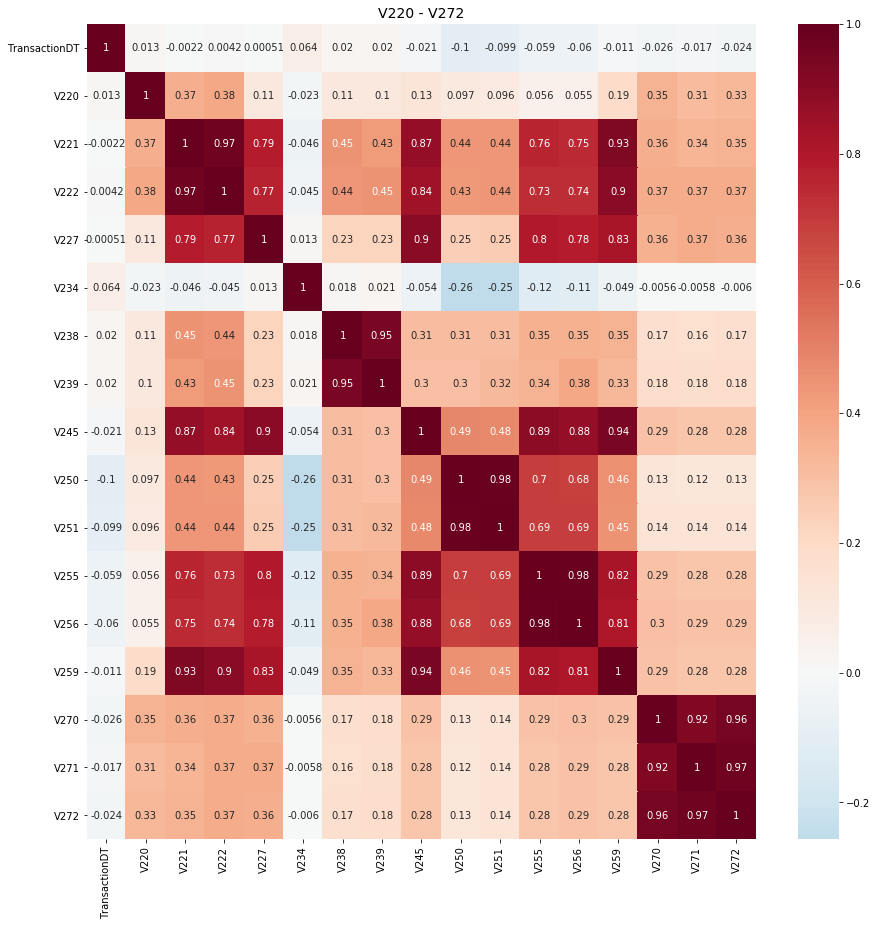

In [49]:
vs = na_groups[449124]
v_correlation(vs)


In [50]:
groups = [[220],[221,222,227,245,255,256,259],[234],[238,239],[250,251],[270,271,272]]
choose_v(groups)


Use these [220, 221, 234, 238, 250, 271]


# V279 - V321

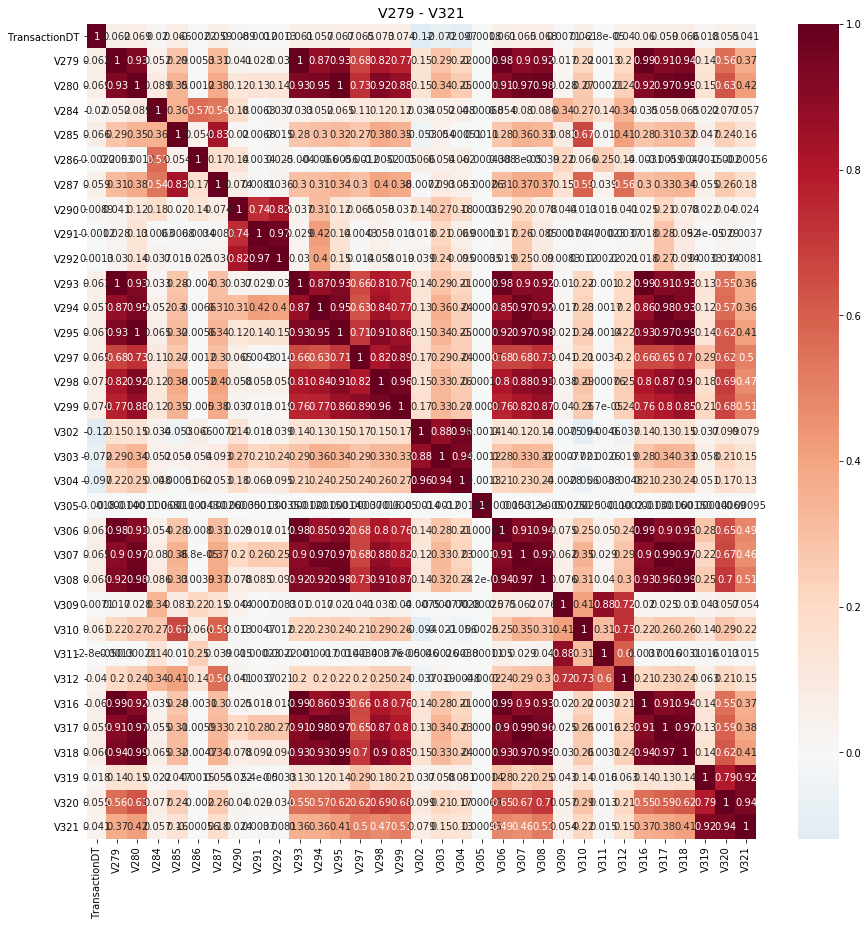

In [51]:
vs = [x for x in na_groups[12]]
v_correlation(vs)


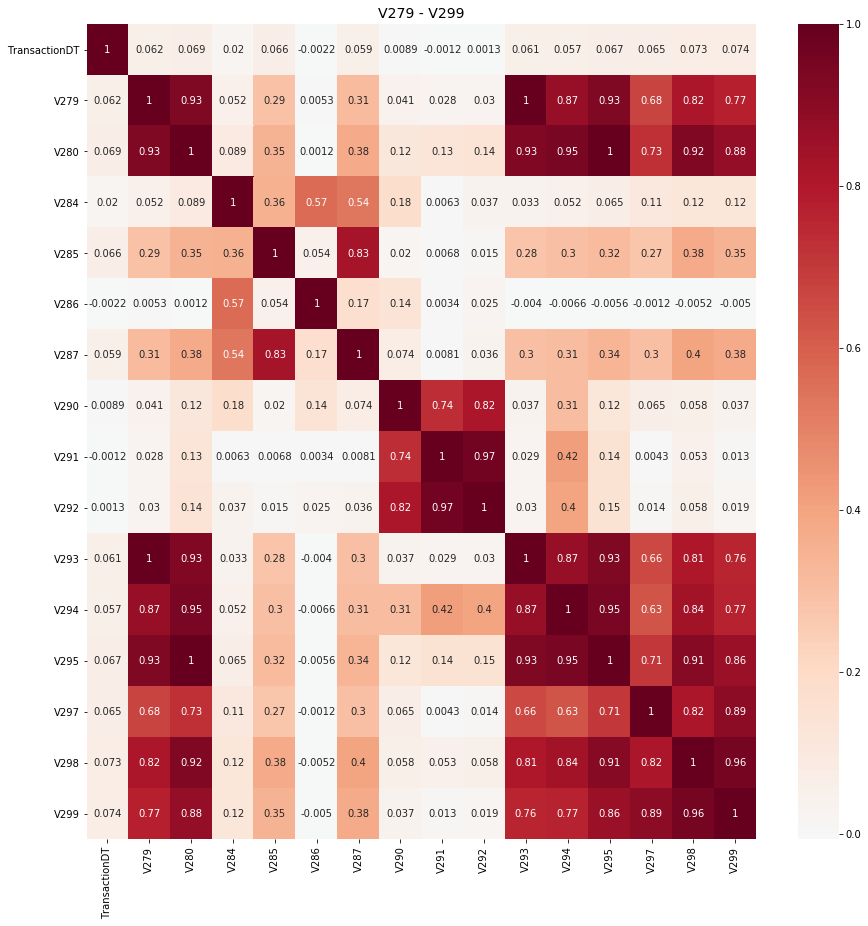

In [52]:
vs = [x for x in na_groups[12] if int(x[1:]) < 302]
v_correlation(vs)


In [53]:
groups = [[279,280,293,294,295,298,299],[284],[285,287],[286],[290,291,292],[297]]
choose_v(groups)


Use these [294, 284, 285, 286, 291, 297]


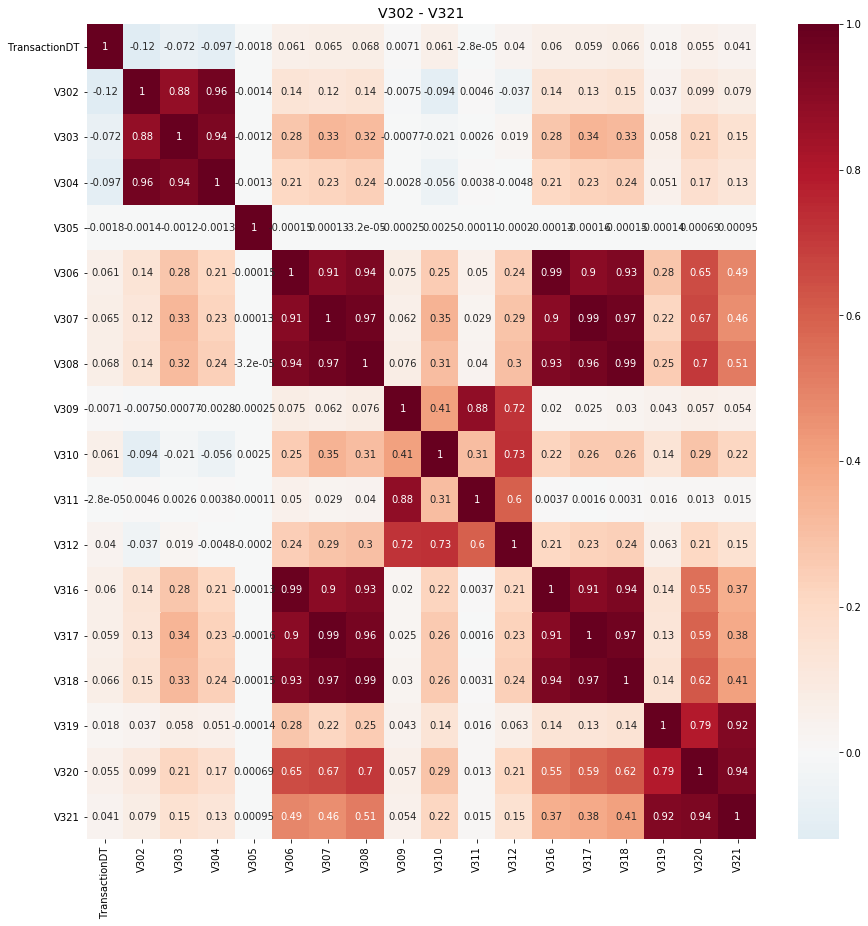

In [54]:
vs = [x for x in na_groups[12] if int(x[1:]) > 299]
v_correlation(vs)

In [55]:
groups = [[302,303,304],[305],[306,307,308,316,317,318],[309,311],[310,312],[319,320,321]]
choose_v(groups)


Use these [303, 305, 307, 309, 310, 320]


# V281 - V315, D1

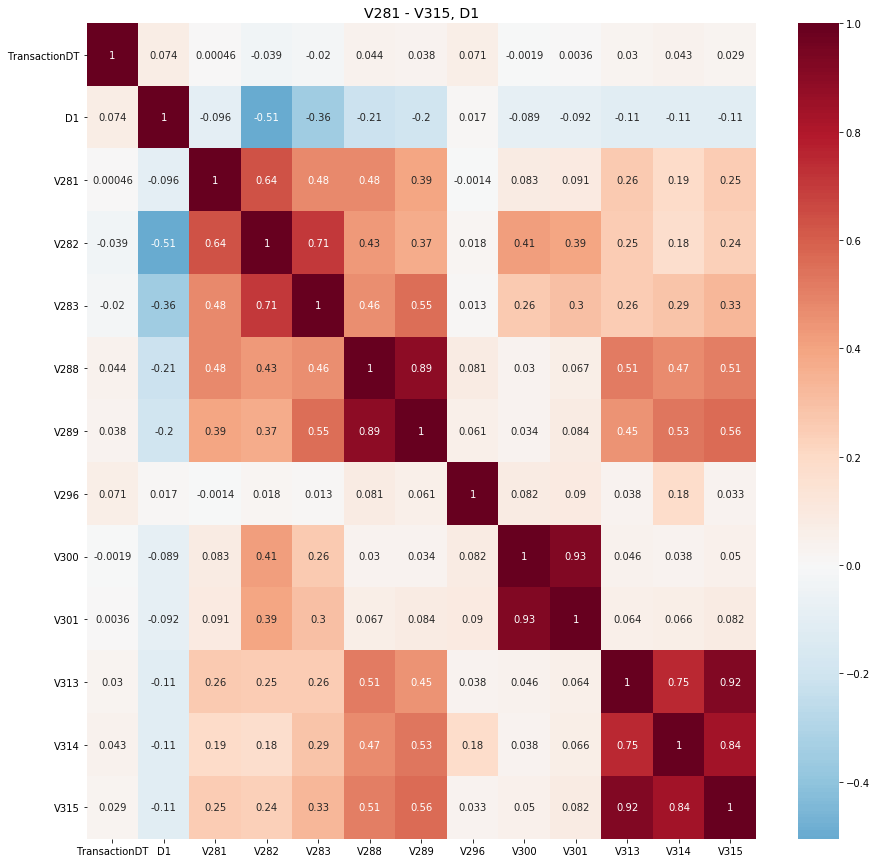

In [56]:
vs = na_groups[1269]
v_title = 'V281 - V315, D1'
v_correlation(vs, v_title)


In [57]:
groups = [[281],[282,283],[288,289],[296],[300,301],[313,314,315]]
choose_v(groups)


Use these [281, 283, 289, 296, 301, 314]


# V322 - V339

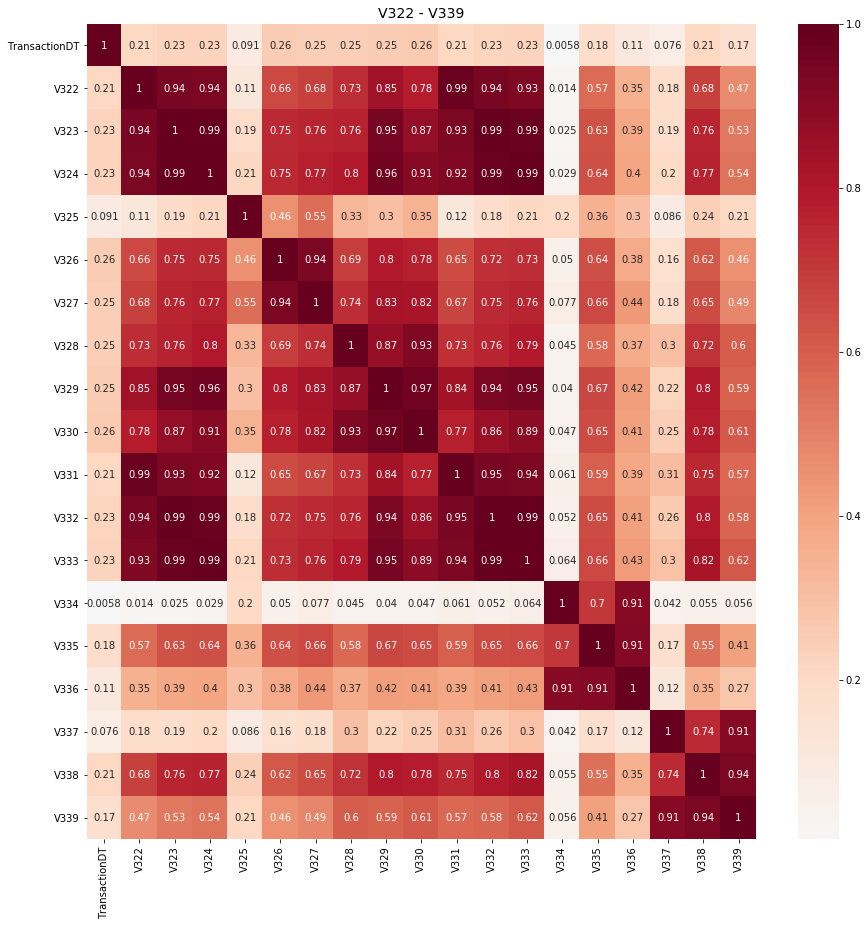

In [58]:
vs = na_groups[508189]
v_correlation(vs)

In [59]:
groups = [[322,323,324,326,327,328,329,330,331,332,333],[325],[334,335,336],[337,338,339]]
choose_v(groups)


Use these [332, 325, 335, 338]


In [60]:
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]
v += [96, 98, 99, 104]
v += [107, 108, 111, 115, 117, 120, 121, 123]
v += [124, 127, 129, 130, 136]
v += [138, 139, 142, 147, 156, 162]
v += [165, 160, 166]
v += [178, 176, 173, 182]
v += [187, 203, 205, 207, 215]
v += [169, 171, 175, 180, 185, 188, 198, 210, 209]
v += [218, 223, 224, 226, 228, 229, 235]
v += [240, 258, 257, 253, 252, 260, 261]
v += [264, 266, 267, 274, 277]
v += [220, 221, 234, 238, 250, 271]
v += [294, 284, 285, 286, 291, 297]
v += [303, 305, 307, 309, 310, 320]
v += [281, 283, 289, 296, 301, 314]
v += [332, 325, 335, 338]

In [182]:
#drop unwanted v columns
v_chosen = ['V'+ str(x) for x in v]
drop_cols = [c for c in cols_v if c not in v_chosen]
#use_cols = [c for c in train.columns if c not in drop_cols]
train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)

In [183]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 2987000 to 3577539
Columns: 209 entries, TransactionDT to DeviceInfo
dtypes: float64(178), int64(2), object(29)
memory usage: 966.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 3663549 to 4170239
Columns: 209 entries, TransactionDT to DeviceInfo
dtypes: float64(178), int64(2), object(29)
memory usage: 811.8+ MB


In [63]:
list = test.isnull().sum()
list.sort_values(ascending=False)

id_03            440210
id_04            440210
D12              437437
id_30            436032
id_33            436020
                  ...  
V108                  0
V107                  0
V104                  0
V99                   0
TransactionDT         0
Length: 209, dtype: int64

# Making additional variables

Changes x = LogTransactionAmt to log(1+x)

In [64]:

def log_trans(df, new_columns=[]):
    df['LogTransactionAmt'] = np.log1p(df['TransactionAmt'])
    new_columns += ['LogTransactionAmt']
    return df


Split rows into the same group if they have the same card1 entry and then change each groups transactionamt column to the average of the transaction amounts in that group. 

This allows us to see the difference between the transaction amount and the average transaction amount on each card


In [65]:
def add_misc_features(df, new_columns=[]):

    df['TransactionAmt_to_mean_card1'] = df['TransactionAmt'] / df.groupby(['card1'])['TransactionAmt'].transform('mean')
    df['TransactionAmt_to_mean_card4'] = df['TransactionAmt'] / df.groupby(['card4'])['TransactionAmt'].transform('mean')
    df['TransactionAmt_to_std_card1'] = df['TransactionAmt'] / df.groupby(['card1'])['TransactionAmt'].transform('std')
    df['TransactionAmt_to_std_card4'] = df['TransactionAmt'] / df.groupby(['card4'])['TransactionAmt'].transform('std')

    df['id_02_to_mean_card1'] = df['id_02'] / df.groupby(['card1'])['id_02'].transform('mean')
    df['id_02_to_mean_card4'] = df['id_02'] / df.groupby(['card4'])['id_02'].transform('mean')
    df['id_02_to_std_card1'] = df['id_02'] / df.groupby(['card1'])['id_02'].transform('std')
    df['id_02_to_std_card4'] = df['id_02'] / df.groupby(['card4'])['id_02'].transform('std')
    
    df['D15_to_mean_card1'] = df['D15'] / df.groupby(['card1'])['D15'].transform('mean')
    df['D15_to_mean_card4'] = df['D15'] / df.groupby(['card4'])['D15'].transform('mean')
    df['D15_to_std_card1'] = df['D15'] / df.groupby(['card1'])['D15'].transform('std')
    df['D15_to_std_card4'] = df['D15'] / df.groupby(['card4'])['D15'].transform('std')

    df['D15_to_mean_addr1'] = df['D15'] / df.groupby(['addr1'])['D15'].transform('mean')
    df['D15_to_mean_addr2'] = df['D15'] / df.groupby(['addr2'])['D15'].transform('mean')
    df['D15_to_std_addr1'] = df['D15'] / df.groupby(['addr1'])['D15'].transform('std')
    df['D15_to_std_addr2'] = df['D15'] / df.groupby(['addr2'])['D15'].transform('std')
    
    df[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = df['P_emaildomain'].str.split('.', expand=True)
    df[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = df['R_emaildomain'].str.split('.', expand=True)

    
    new_columns += ['TransactionAmt_to_mean_card1', 'TransactionAmt_to_mean_card4', 'TransactionAmt_to_std_card1', 'TransactionAmt_to_std_card4',
                    'id_02_to_mean_card1', 'id_02_to_mean_card4', 'id_02_to_std_card1', 'id_02_to_std_card4', 'D15_to_mean_card1', 
                    'D15_to_mean_card4', 'D15_to_std_card1', 'D15_to_std_card4', 'D15_to_mean_addr1', 'D15_to_mean_addr2', 'D15_to_std_addr1', 
                    'D15_to_std_addr2', 'P_emaildomain_1', 'R_emaildomain_1']
    return df

Incorporate the potential significance of 2 rows having both the same card1 and card2 entries

In [66]:

def add_uid_features(df, new_columns=[]): 
    df['uid1'] = df['card1'].astype(str) + '_' + df['card2'].astype(str)
    df['uid2'] = df['uid1'].astype(str) + '_' + df['card3'].astype(str) + '_' + df['card5'].astype(str)
    df['uid3'] = df['uid2'].astype(str) + '_' + df['addr1'].astype(str) + '_' + df['addr2'].astype(str)
    
    
    new_columns += ['uid1', 'uid2', 'uid3']
    return df

Create a vraible that may help highlight if more fraud occurs on a certain day of the week or time of day

In [67]:

def add_time_features_1(df, new_columns=[]):
    df['Transaction_day_of_week'] = np.floor((df['TransactionDT'] / (3600 * 24) - 1) % 7)
    df['Transaction_hour_of_day'] = np.floor(df['TransactionDT'] / 3600) % 24
    df['Transaction_hour'] = np.floor(df['TransactionDT'] / 3600) % 24
    df['TransactionAmt_decimal'] = ((df['TransactionAmt'] - df['TransactionAmt'].astype(int)) * 1000).astype(int)
    
    new_columns += ['Transaction_day_of_week', 'Transaction_hour_of_day', 'Transaction_hour', 'TransactionAmt_decimal']
    return df



Find when in the calender year the transaction took place which may highlight if at a certain time of year more fraud happens, for example christmas 

In [68]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import datetime
dates_range = pd.date_range(start='2017-10-01', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())



def add_time_features_2(df, new_columns=[]):
   
    START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['DT_M'] = ((df['DT'].dt.year-2017)*12 + df['DT'].dt.month).astype(np.int8)
    df['DT_W'] = ((df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear).astype(np.int8)
    df['DT_D'] = ((df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear).astype(np.int16)
    
    df['DT_hour'] = (df['DT'].dt.hour).astype(np.int8)
    df['DT_day_week'] = (df['DT'].dt.dayofweek).astype(np.int8)
    df['DT_day_month'] = (df['DT'].dt.day).astype(np.int8)
      

    # Possible solo feature
    df['is_december'] = df['DT'].dt.month
    df['is_december'] = (df['is_december']==12).astype(np.int8)

    # Holidays
    df['is_holiday'] = (df['DT'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)
    
    new_columns += ['DT', 'DT_M', 'DT_W', 'DT_D', 'DT_hour', 'DT_day_week', 'DT_day_month', 'is_december', 'is_holiday']
    return df

Create a variable 'protonmail', an encrypted email service used by fraudsters due to lack of traceability

In [69]:

def add_proton_check(df, new_columns=[]):
    df['P_isproton'] = (df['P_emaildomain']=='protonmail.com')
    df['R_isproton'] = (df['R_emaildomain']=='protonmail.com')

    new_columns += ['P_isproton', 'R_isproton']
    return df

Group variations of email names to the same name
Group into domains owned by the same company, for example microsoft owns hotmail 

In [70]:

emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other',
          'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft',
          'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other',
          'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo',
          'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo',
          'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo',
          'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo',
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other',
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple',
          'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other',
          'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

def add_domain_1(df, new_columns=[]):
    for c in ['P_emaildomain', 'R_emaildomain']:
        df[c + '_bin'] = df[c].map(emails)
    #seperating the domain name from the full email entry
        df[c + '_suffix'] = df[c].map(lambda x: str(x).split('.')[-1])
    #collapsing the 3 US emails down to the same "us" entry
        df[c + '_suffix'] = df[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

    new_columns += ['P_emaildomain_bin', 'P_emaildomain_suffix', 'R_emaildomain_bin', 'R_emaildomain_suffix']
    return df

Check if P_emaildomain matches R_emaildomain, aassign 1 when emails match and 0 when they dont

In [71]:
def add_domain_2(df, new_columns=[]):
    p = 'P_emaildomain'
    r = 'R_emaildomain'
    uknown = 'email_not_provided'

    df[p] = df[p].fillna(uknown)
    df[r] = df[r].fillna(uknown)
    
    df['email_check'] = np.where((df[p]==df[r]) & (df[p]!=uknown),1,0)

    df[p+'_prefix'] = df[p].apply(lambda x: x.split('.')[0])
    df[r+'_prefix'] = df[r].apply(lambda x: x.split('.')[0])
    
    new_columns += ['email_check', 'P_emaildomain_prefix', 'R_emaildomain_prefix']
    return df

In [72]:
def add_browser(df, new_columns=[]):
    df["lastest_browser"] = np.zeros(df.shape[0])
    df.loc[df["id_31"] == "samsung browser 7.0",'lastest_browser']=1
    df.loc[df["id_31"] == "opera 53.0",'lastest_browser']=1
    df.loc[df["id_31"] == "mobile safari 10.0",'lastest_browser']=1
    df.loc[df["id_31"] == "google search application 49.0",'lastest_browser']=1
    df.loc[df["id_31"] == "firefox 60.0",'lastest_browser']=1
    df.loc[df["id_31"] == "edge 17.0",'lastest_browser']=1
    df.loc[df["id_31"] == "chrome 69.0",'lastest_browser']=1
    df.loc[df["id_31"] == "chrome 67.0 for android",'lastest_browser']=1
    df.loc[df["id_31"] == "chrome 63.0 for android",'lastest_browser']=1
    df.loc[df["id_31"] == "chrome 63.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"] == "chrome 64.0",'lastest_browser']=1
    df.loc[df["id_31"] == "chrome 64.0 for android",'lastest_browser']=1
    df.loc[df["id_31"] == "chrome 64.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"] == "chrome 65.0",'lastest_browser']=1
    df.loc[df["id_31"] == "chrome 65.0 for android",'lastest_browser']=1
    df.loc[df["id_31"] == "chrome 65.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"] == "chrome 66.0",'lastest_browser']=1
    df.loc[df["id_31"] == "chrome 66.0 for android",'lastest_browser']=1
    df.loc[df["id_31"] == "chrome 66.0 for ios",'lastest_browser']=1

    new_columns += ['lastest_browser']
    return df

Group variations on the same device name into one label

In [73]:

def add_device_type(df, new_columns=[]):
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    
    df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]

    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'
    df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    
    df['had_id'] = 1
    gc.collect()
    
    new_columns += ['device_name']
    return df

In [184]:
def add_new_features(df):
    new_features = []
    df = log_trans(df, new_features)
    #df = add_misc_features(df, new_features)
    df = add_uid_features(df, new_features)
    df = add_time_features_1(df, new_features)
    #df = add_time_features_2(df, new_features)
    df = add_proton_check(df, new_features)
    df = add_domain_1(df, new_features)
    df = add_domain_2(df, new_features)
    df = add_browser(df, new_features)
    df = add_device_type(df, new_features)

    return df, new_features

train, new_features = add_new_features(train)
test, new_features = add_new_features(test)
print(len(new_features))
print(train.shape)
print(test.shape)

19
(590540, 229)
(506691, 229)


In [185]:
test.info()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 3663549 to 4170239
Columns: 229 entries, TransactionDT to had_id
dtypes: bool(2), float64(183), int64(5), object(39)
memory usage: 882.4+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 2987000 to 3577539
Columns: 229 entries, TransactionDT to had_id
dtypes: bool(2), float64(183), int64(5), object(39)
memory usage: 1.0+ GB


# Impute Values

Redefine the categorical and numerical groups as we have engineered new variables

In [76]:

drop_na = ['isFraud']


In [186]:
num_cols = train.select_dtypes(include = np.number).columns
num_cols_test = [c for c in num_cols if c not in drop_na]

train[num_cols] = train[num_cols].fillna(train[num_cols].mean())
test[num_cols_test] = test[num_cols_test].fillna(test[num_cols_test].mean())

In [187]:
cat_cols = train.select_dtypes(include = 'object').columns

train[cat_cols] = train[cat_cols].fillna(train[cat_cols].mode().iloc[0])
test[cat_cols] = test[cat_cols].fillna(train[cat_cols].mode().iloc[0])

In [188]:
test.info()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 3663549 to 4170239
Columns: 229 entries, TransactionDT to had_id
dtypes: bool(2), float64(183), int64(5), object(39)
memory usage: 882.4+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 2987000 to 3577539
Columns: 229 entries, TransactionDT to had_id
dtypes: bool(2), float64(183), int64(5), object(39)
memory usage: 1.0+ GB


# Encode

Encode the categorical data into numerics to ensure the covariates are in a suitable form for the model

In [189]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

train[cat_cols] = ordinal_encoder.fit_transform(train[cat_cols])
test[cat_cols] = ordinal_encoder.fit_transform(test[cat_cols])


In [81]:
train = train.merge(y_train, how='left', left_index=True, right_index=True)

In [82]:
corr_matrix = train.corr()
abs(corr_matrix["isFraud"]).sort_values(ascending=False)

isFraud    1.000000
V257       0.262946
V86        0.224530
V44        0.218669
V188       0.217058
             ...   
V210       0.000467
M2         0.000185
id_36      0.000163
V136       0.000042
had_id          NaN
Name: isFraud, Length: 230, dtype: float64

In [83]:
train["D1"].dtypes

dtype('float64')

# Gradient Boosting Model

Fit a gradient boosting model to the data

In [84]:
# split X and y into training and testing sets
x = train.drop('isFraud', axis=1)

y = train['isFraud']

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 0)


In [91]:
x.shape


(590540, 229)

In [92]:
y.shape

(590540,)

In [93]:
import xgboost as xgb
from xgboost import XGBClassifier

# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=x,label=y)

# declare parameters
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100
        }      
           
          
# instantiate the classifier 
xgb_clf = XGBClassifier(**params)


# fit the classifier to the training data
xgb_clf.fit(x, y)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=1.0, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [94]:
y_pred = xgb_clf.predict(x_val)

In [95]:
from sklearn.metrics import accuracy_score

print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_val, y_pred)))

XGBoost model accuracy score: 0.9812


3-fold cross-validation to begin reducing generlaisation error

In [96]:
from xgboost import cv

params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

In [97]:
xgb_cv.head()

train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.753882       0.000838       0.753927      0.004779
1        0.800565       0.001793       0.802290      0.006837
2        0.817263       0.009544       0.817953      0.014144
3        0.825403       0.007501       0.826381      0.010077
4        0.833698       0.007822       0.833951      0.004921

Plot the feature importance

In [98]:
xgb.plot_importance(xgb_clf)
plt.figure(figsize = (16, 12))
plt.show()

<Figure size 1152x864 with 0 Axes>

# Tune Hyperparameters

Here the following hyperparameters are tuned using both the train and validation data:

max_depth: the maximum number of nodes allowed from the root to the farthest leaf of a tree. 

subsample: the fraction of observations (the rows) to subsample at each step.

learning rate: the shrinkage you do at every step you are making

n_estimators: the number of runs XGBoost will try to learn

In [99]:
set.seed(123)
train_samp = train.sample(n = 1000)

y_train_samp = train_samp["isFraud"]
train_samp = train_samp.drop(columns="isFraud")

In [100]:
x_samp, y_samp = train_samp , y_train_samp
x_train_samp, x_val_samp, y_train_samp, y_val_samp = train_test_split(x_samp, y_samp, test_size = 0.2, random_state = 0)

In [148]:
max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for max_depth in max_depths:
    gb = XGBClassifier(max_depth = max_depth)
    gb.fit(x_train_samp, y_train_samp)
    print("Max Depth: ", max_depth)
    print("Accuracy score (training): {0:.3f}".format(gb.score(x_train_samp, y_train_samp)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(x_val_samp, y_val_samp)))
    print()

Max Depth:  1
Accuracy score (training): 0.976
Accuracy score (validation): 0.990

Max Depth:  2
Accuracy score (training): 0.991
Accuracy score (validation): 0.985

Max Depth:  3
Accuracy score (training): 0.999
Accuracy score (validation): 0.980

Max Depth:  4
Accuracy score (training): 1.000
Accuracy score (validation): 0.985

Max Depth:  5
Accuracy score (training): 1.000
Accuracy score (validation): 0.980

Max Depth:  6
Accuracy score (training): 1.000
Accuracy score (validation): 0.980

Max Depth:  7
Accuracy score (training): 1.000
Accuracy score (validation): 0.980

Max Depth:  8
Accuracy score (training): 1.000
Accuracy score (validation): 0.980

Max Depth:  9
Accuracy score (training): 1.000
Accuracy score (validation): 0.980

Max Depth:  10
Accuracy score (training): 1.000
Accuracy score (validation): 0.980



In [227]:
learning_rates = [0.05, 0.1, 0.25, 0.3, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = XGBClassifier(learning_rate = learning_rate)
    gb.fit(x_train_samp, y_train_samp)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(x_train_samp, y_train_samp)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(x_val_samp, y_val_samp)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.990
Accuracy score (validation): 0.980

Learning rate:  0.1
Accuracy score (training): 0.999
Accuracy score (validation): 0.980

Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.980

Learning rate:  0.3
Accuracy score (training): 1.000
Accuracy score (validation): 0.980

Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 0.980

Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.980

Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.980



In [144]:
subsamples = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for subsample in subsamples:
    gb = XGBClassifier(subsample = subsample)
    gb.fit(x_train_samp, y_train_samp)
    print("subsample: ", subsample)
    print("Accuracy score (training): {0:.3f}".format(gb.score(x_train_samp, y_train_samp)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(x_val_samp, y_val_samp)))
    print()

subsample:  0.05
Accuracy score (training): 0.965
Accuracy score (validation): 0.985

subsample:  0.1
Accuracy score (training): 0.973
Accuracy score (validation): 0.985

subsample:  0.25
Accuracy score (training): 0.981
Accuracy score (validation): 0.980

subsample:  0.5
Accuracy score (training): 0.994
Accuracy score (validation): 0.985

subsample:  0.75
Accuracy score (training): 0.998
Accuracy score (validation): 0.990

subsample:  1
Accuracy score (training): 0.999
Accuracy score (validation): 0.980



In [145]:
n_estimatorss = [100, 200, 300, 400, 500, 600]
for n_estimators in n_estimatorss:
    gb = XGBClassifier(n_estimators = n_estimators)
    gb.fit(x_train_samp, y_train_samp)
    print("n_estimators: ", n_estimators)
    print("Accuracy score (training): {0:.3f}".format(gb.score(x_train_samp, y_train_samp)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(x_val_samp, y_val_samp)))
    print()

n_estimators:  100
Accuracy score (training): 0.999
Accuracy score (validation): 0.980

n_estimators:  200
Accuracy score (training): 1.000
Accuracy score (validation): 0.980

n_estimators:  300
Accuracy score (training): 1.000
Accuracy score (validation): 0.980

n_estimators:  400
Accuracy score (training): 1.000
Accuracy score (validation): 0.980

n_estimators:  500
Accuracy score (training): 1.000
Accuracy score (validation): 0.980

n_estimators:  600
Accuracy score (training): 1.000
Accuracy score (validation): 0.980



Despite the max-depth being shown as optimal at 1, after trial and error this was shown to decrease the accuracy score in comparison to a max depth of 4. We therefore run the model with the following parameters:

In [231]:
import xgboost as xgb
from xgboost import XGBClassifier

# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=x,label=y)

# declare parameters
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'subsample' : 1,
            'learning_rate': 1,
            'n_estimators':100
        }      
           
          
# instantiate the classifier 
xgb_clf = XGBClassifier(**params)


# fit the classifier to the training data
xgb_clf.fit(x, y)

y_pred = xgb_clf.predict(x_val)

from sklearn.metrics import accuracy_score

print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_val, y_pred)))

XGBoost model accuracy score: 0.9812


# perfomance evaluation

Cross validate using a 3-fold cross validation, and calculate the mean and sd of the AUC for both the train and validation datasets.

In [150]:
from xgboost import cv

xgb_cv = cv(dtrain=data_dmatrix, params = params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

In [151]:
xgb_cv.head()

train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.590004       0.001124       0.590013      0.002245
1        0.625035       0.002536       0.624719      0.002382
2        0.694290       0.002488       0.694213      0.001839
3        0.727072       0.029858       0.725697      0.024634
4        0.755918       0.016764       0.754630      0.012496

calculate the confusion matrix

In [158]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion = confusion_matrix(y_val , y_pred, labels=[1,0])
print('Confusion matrix : \n',matrix)



Confusion matrix : 
 [[  2277   1775]
 [   373 113683]]


calculate the sensitivity and specifcity

In [159]:
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

In [160]:
sensitivity = TP / float(FN + TP)

print(sensitivity)


0.9960984077996774


In [161]:
specificity = TN / (TN + FP)

print(specificity)

0.5444225074037512


# Predict to Test Data

In [190]:
test.shape

(506691, 229)

In [191]:
prediction = xgb_clf.predict(test)

In [165]:
prediction.shape

(506691,)

In [193]:
test_data = test

In [196]:
test_data = test_data.reset_index(level=0)

In [202]:
test_data.drop(test_data.columns.difference(['TransactionID']), 1, inplace=True)

In [217]:
isFraud = xgb_clf.predict(test)

In [218]:
test_data["isFraud"] = isFraud.tolist()

In [224]:
boo = test_data.drop(columns = ["prediction"])

In [226]:
boo.head

<bound method NDFrame.head of         TransactionID  isFraud
0             3663549        0
1             3663550        0
2             3663551        0
3             3663552        0
4             3663553        0
...               ...      ...
506686        4170235        0
506687        4170236        0
506688        4170237        0
506689        4170238        0
506690        4170239        0

[506691 rows x 2 columns]>

In [225]:
boo.to_csv("Boo.csv")